# Expand Dataset with Additional Countries
## Data collection for expanded training dataset

Goal: collect world bank data for additional countries to expand from 3 countries (42 rows) to ~15-17 countries (~200+ rows)

Countries to add:
- High-risk (5): Angola, Venezuela, Zimbabwe, Iraq, Ukraine
- Medium-risk (4): Brazil, South Africa, India, Philippines  
- Low-risk (7): Norway, Denmark, Singapore, Australia, New Zealand, Switzerland, Germany

Timeframe: 2010-2023 (same as baseline)


In [1]:
import wbdata
import pandas as pd
import datetime
import os

# set working directory to project root
# if running from notebooks/, go up one level; otherwise assume already at root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    # if notebooks is in the path, go to project root
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

# verify we're in the right place
print(f"Working directory: {os.getcwd()}")
print(f"Data file exists: {os.path.exists('data/raw/corruption_data_baseline.csv')}")


Working directory: /Users/snitil/Library/CloudStorage/OneDrive-McGillUniversity/McGill/U3/F2025/ECON302/innovationshowcase
Data file exists: True


## Setting up country lists by risk category


In [2]:
# original baseline countries (already have data)
baseline_countries = {
    'CAN': 'Canada',  # low-risk control
    'MYS': 'Malaysia',  # high-risk (1MDB)
    'MOZ': 'Mozambique'  # high-risk (hidden debt)
}

# high-risk countries: known corruption scandals, weak governance
high_risk_countries = {
    'AGO': 'Angola',  # oil revenue corruption
    'VEN': 'Venezuela',  # PDVSA corruption, collapsing governance
    'ZWE': 'Zimbabwe',  # infrastructure project corruption
    'IRQ': 'Iraq',  # reconstruction fund corruption
    'UKR': 'Ukraine'  # pre-2014 development fund issues
}

# medium-risk countries: mixed governance scores, isolated incidents
medium_risk_countries = {
    'BRA': 'Brazil',  # lava jato but stronger institutions
    'ZAF': 'South Africa',  # state capture but decent baseline
    'IND': 'India',  # mixed governance, large economy
    'PHL': 'Philippines'  # variable governance scores
}

# low-risk countries: stable, high-governance
low_risk_countries = {
    'NOR': 'Norway',  # consistently top scores
    'DNK': 'Denmark',  # strong anti-corruption
    'SGP': 'Singapore',  # high effectiveness and rule of law
    'AUS': 'Australia',  # stable governance
    'NZL': 'New Zealand',  # clean governance record
    'CHE': 'Switzerland',  # strong institutions
    'DEU': 'Germany'  # solid governance throughout period
}

# combine all new countries (excluding baseline)
all_new_countries = {**high_risk_countries, **medium_risk_countries, **low_risk_countries}

print(f"baseline countries: {len(baseline_countries)}")
print(f"high-risk countries: {len(high_risk_countries)}")
print(f"medium-risk countries: {len(medium_risk_countries)}")
print(f"low-risk countries: {len(low_risk_countries)}")
print(f"total new countries: {len(all_new_countries)}")
print(f"\nnew country codes: {list(all_new_countries.keys())}")


baseline countries: 3
high-risk countries: 5
medium-risk countries: 4
low-risk countries: 7
total new countries: 16

new country codes: ['AGO', 'VEN', 'ZWE', 'IRQ', 'UKR', 'BRA', 'ZAF', 'IND', 'PHL', 'NOR', 'DNK', 'SGP', 'AUS', 'NZL', 'CHE', 'DEU']


## Defining indicators (same as baseline)


In [3]:
# defining all indicators we want to pull
# same as baseline notebook - split into governance indicators (main focus) and economic indicators (context)

indicators = {
    # governance indicators - these match table 1 from morgan's case study
    'VA.EST': 'Voice_Accountability',
    'PV.EST': 'Political_Stability',
    'GE.EST': 'Government_Effectiveness',
    'RQ.EST': 'Regulatory_Quality',
    'RL.EST': 'Rule_of_Law',
    'CC.EST': 'Control_of_Corruption',
    
    # economic indicators - useful for detecting financial patterns
    'DT.DOD.DECT.GN.ZS': 'External_Debt_perc_GNI',
    'NY.GDP.MKTP.KD.ZG': 'GDP_Growth_annual_perc',
    'GC.XPN.TOTL.GD.ZS': 'Govt_Expenditure_perc_GDP',
    'BX.KLT.DINV.WD.GD.ZS': 'FDI_Inflows_perc_GDP',
    'SI.POV.DDAY': 'Poverty_Headcount_Ratio'
}


## Loading baseline data


In [4]:
# load the baseline data
df_baseline = pd.read_csv('data/raw/corruption_data_baseline.csv')

# drop 2024 data (incomplete governance data, same as notebook 02)
print(f"baseline dataset shape before dropping 2024: {df_baseline.shape[0]} rows")
# handle both string and numeric year values
df_baseline = df_baseline[(df_baseline['Year'] != 2024) & (df_baseline['Year'] != '2024')].copy()
print(f"baseline dataset shape after dropping 2024: {df_baseline.shape[0]} rows, {df_baseline.shape[1]} columns")
print(f"baseline countries: {df_baseline['Country'].unique()}")
print(f"baseline years: {df_baseline['Year'].min()} to {df_baseline['Year'].max()}")


baseline dataset shape before dropping 2024: 45 rows
baseline dataset shape after dropping 2024: 42 rows, 13 columns
baseline countries: ['Canada' 'Malaysia' 'Mozambique']
baseline years: 2010 to 2023


## Fetching data from world bank api for new countries


In [5]:
# date range for historical data
# excluding 2024 as it has incomplete governance data (same as baseline processing)
data_range = (datetime.datetime(2010, 1, 1), datetime.datetime(2023, 12, 31))

# get country codes for new countries
new_country_codes = list(all_new_countries.keys())

# fetching data from api
# get_dataframe pulls all indicators for specified countries and dates
df_new = wbdata.get_dataframe(indicators, 
                              country=new_country_codes, 
                              date=data_range,
                              parse_dates=False)  # keep dates as year strings


## Cleaning and formatting the dataframe


In [6]:
# reset index so country and date become regular columns
df_new = df_new.reset_index()
df_new = df_new.rename(columns={'date': 'Year', 'country': 'Country'})

# normalize country names (remove World Bank suffixes for consistency)
# e.g., "Venezuela, RB" -> "Venezuela"
df_new['Country'] = df_new['Country'].str.replace(', RB', '', regex=False)
df_new['Country'] = df_new['Country'].str.replace(', Bolivarian Republic of', '', regex=False)

# reorder columns for readability
column_order = ['Country', 'Year'] + list(indicators.values())
existing_columns = [col for col in column_order if col in df_new.columns]
df_new = df_new[existing_columns]

# sort by country then year
df_new = df_new.sort_values(by=['Country', 'Year']).reset_index(drop=True)


## Inspecting the data


In [7]:
print(f"shape: {df_new.shape[0]} rows, {df_new.shape[1]} columns")
print(f"years covered: {df_new['Year'].min()} to {df_new['Year'].max()}")
print(f"\ncountries in new data:")
print(df_new['Country'].unique())

# checking for missing values
print("\nmissing values per column:")
print(df_new.isnull().sum())
print(f"\nmissing data percentage:")
print(round(df_new.isnull().sum() / len(df_new) * 100, 2))


shape: 224 rows, 13 columns
years covered: 2010 to 2023

countries in new data:
['Angola' 'Australia' 'Brazil' 'Denmark' 'Germany' 'India' 'Iraq'
 'New Zealand' 'Norway' 'Philippines' 'Singapore' 'South Africa'
 'Switzerland' 'Ukraine' 'Venezuela' 'Zimbabwe']

missing values per column:
Country                        0
Year                           0
Voice_Accountability           0
Political_Stability            0
Government_Effectiveness       0
Regulatory_Quality             0
Rule_of_Law                    0
Control_of_Corruption          0
External_Debt_perc_GNI       117
GDP_Growth_annual_perc         9
Govt_Expenditure_perc_GDP     41
FDI_Inflows_perc_GDP           9
Poverty_Headcount_Ratio      128
dtype: int64

missing data percentage:
Country                       0.00
Year                          0.00
Voice_Accountability          0.00
Political_Stability           0.00
Government_Effectiveness      0.00
Regulatory_Quality            0.00
Rule_of_Law                   0.00

## Combining with baseline data


In [8]:
# combine baseline and new data
# ensure same columns
common_columns = list(set(df_baseline.columns) & set(df_new.columns))
df_baseline_subset = df_baseline[common_columns]
df_new_subset = df_new[common_columns]

# combine
df_expanded = pd.concat([df_baseline_subset, df_new_subset], ignore_index=True)

# sort by country then year
df_expanded = df_expanded.sort_values(by=['Country', 'Year']).reset_index(drop=True)

print(f"combined dataset shape: {df_expanded.shape[0]} rows, {df_expanded.shape[1]} columns")
print(f"total countries: {df_expanded['Country'].nunique()}")
print(f"\ncountries in expanded dataset:")
print(sorted(df_expanded['Country'].unique()))


combined dataset shape: 266 rows, 13 columns
total countries: 19

countries in expanded dataset:
['Angola', 'Australia', 'Brazil', 'Canada', 'Denmark', 'Germany', 'India', 'Iraq', 'Malaysia', 'Mozambique', 'New Zealand', 'Norway', 'Philippines', 'Singapore', 'South Africa', 'Switzerland', 'Ukraine', 'Venezuela', 'Zimbabwe']


## Saving to data/raw/


In [9]:
# create directory if it doesn't exist
os.makedirs('data/raw', exist_ok=True)

# save the expanded dataset
output_path = 'data/raw/corruption_data_expanded.csv'
df_expanded.to_csv(output_path, index=False)

print(f"saved to: {output_path}")


saved to: data/raw/corruption_data_expanded.csv


## Quick analysis of governance indicators

checking how new countries compare across the six governance indicators


In [10]:
# filtering to just governance indicators
governance_cols = ['Country', 'Year', 'Voice_Accountability', 'Political_Stability', 
                   'Government_Effectiveness', 'Regulatory_Quality', 'Rule_of_Law', 
                   'Control_of_Corruption']

gov_df = df_expanded[governance_cols]

# calculate average scores by country
print("average governance scores by country (2010-2023):")
print(gov_df.groupby('Country')[governance_cols[2:]].mean().round(2))


average governance scores by country (2010-2023):
              Voice_Accountability  Political_Stability  \
Country                                                   
Angola                       -0.99                -0.42   
Australia                     1.39                 0.94   
Brazil                        0.40                -0.32   
Canada                        1.44                 1.04   
Denmark                       1.57                 0.93   
Germany                       1.40                 0.71   
India                         0.31                -0.96   
Iraq                         -1.03                -2.30   
Malaysia                     -0.26                 0.14   
Mozambique                   -0.40                -0.62   
New Zealand                   1.58                 1.42   
Norway                        1.70                 1.16   
Philippines                   0.01                -1.03   
Singapore                    -0.11                 1.38   
South 

## Visualizations for expanded dataset

creating visualizations to explore the expanded dataset across all countries


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# create results directory for notebook 03 figures
os.makedirs('results/figures/03', exist_ok=True)
print("Figures will be saved to: results/figures/03/")


### Governance scores by risk category





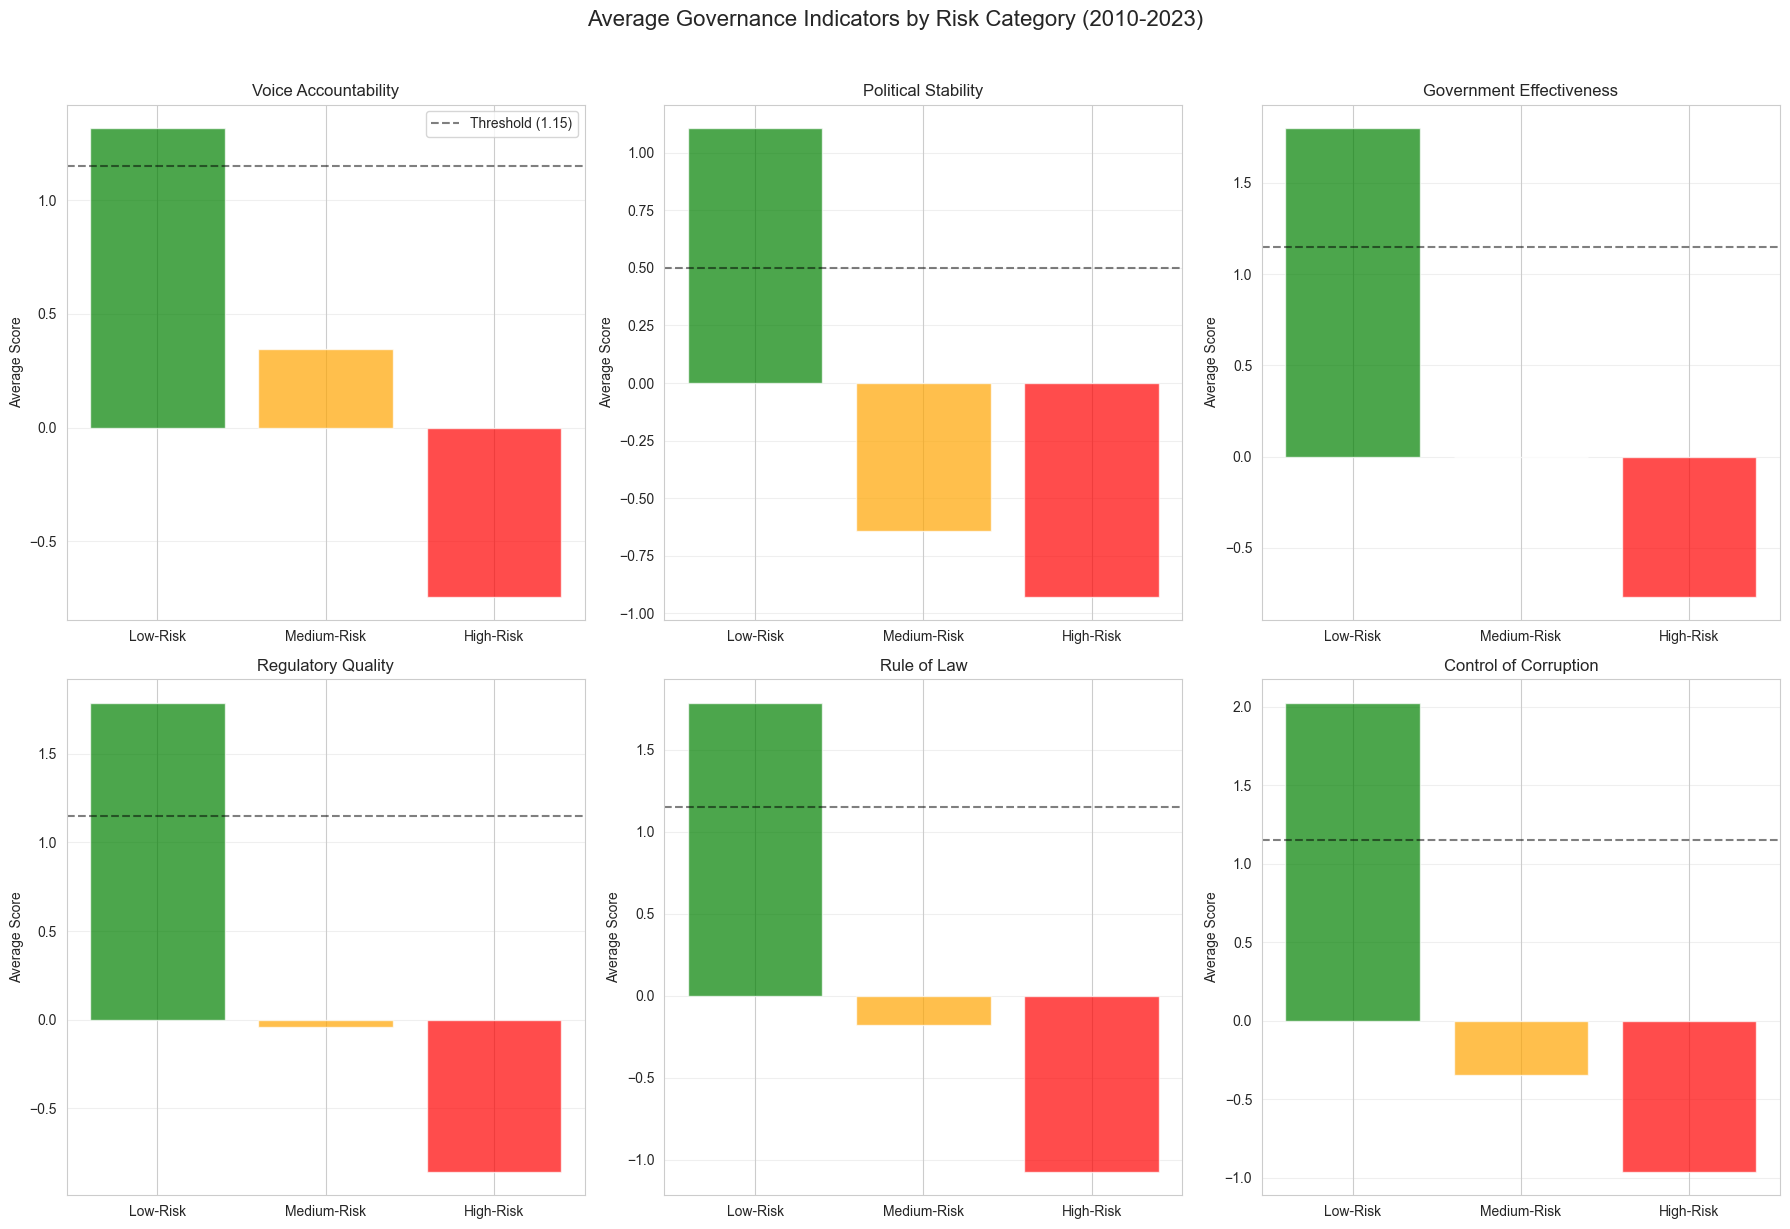

In [ ]:
# categorize countries by risk level for visualization
high_risk_list = ['Angola', 'Venezuela', 'Zimbabwe', 'Iraq', 'Ukraine', 'Malaysia', 'Mozambique']
medium_risk_list = ['Brazil', 'South Africa', 'India', 'Philippines']
low_risk_list = ['Norway', 'Denmark', 'Singapore', 'Australia', 'New Zealand', 'Switzerland', 'Germany', 'Canada']

# add risk category to dataframe
def assign_risk_category(country):
    if country in high_risk_list:
        return 'High-Risk'
    elif country in medium_risk_list:
        return 'Medium-Risk'
    else:
        return 'Low-Risk'

df_expanded['Risk_Category'] = df_expanded['Country'].apply(assign_risk_category)

# plot average governance scores by risk category
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Average Governance Indicators by Risk Category (2010-2023)', fontsize=16, y=1.02)

indicators = ['Voice_Accountability', 'Political_Stability', 'Government_Effectiveness', 
              'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption']

for idx, indicator in enumerate(indicators):
    ax = axes[idx // 3, idx % 3]
    
    # calculate averages by risk category
    category_means = df_expanded.groupby('Risk_Category')[indicator].mean().sort_values(ascending=False)
    
    # create bar plot
    colors = {'High-Risk': 'red', 'Medium-Risk': 'orange', 'Low-Risk': 'green'}
    bars = ax.bar(category_means.index, category_means.values, 
                  color=[colors[cat] for cat in category_means.index], alpha=0.7)
    
    # add threshold line if applicable
    if indicator != 'Political_Stability':
        threshold = 1.15
        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    else:
        threshold = 0.50
        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    
    ax.set_title(indicator.replace('_', ' '), fontsize=12)
    ax.set_ylabel('Average Score')
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.savefig('results/figures/03/expanded_governance_by_risk_category.png', dpi=300, bbox_inches='tight')
plt.show()


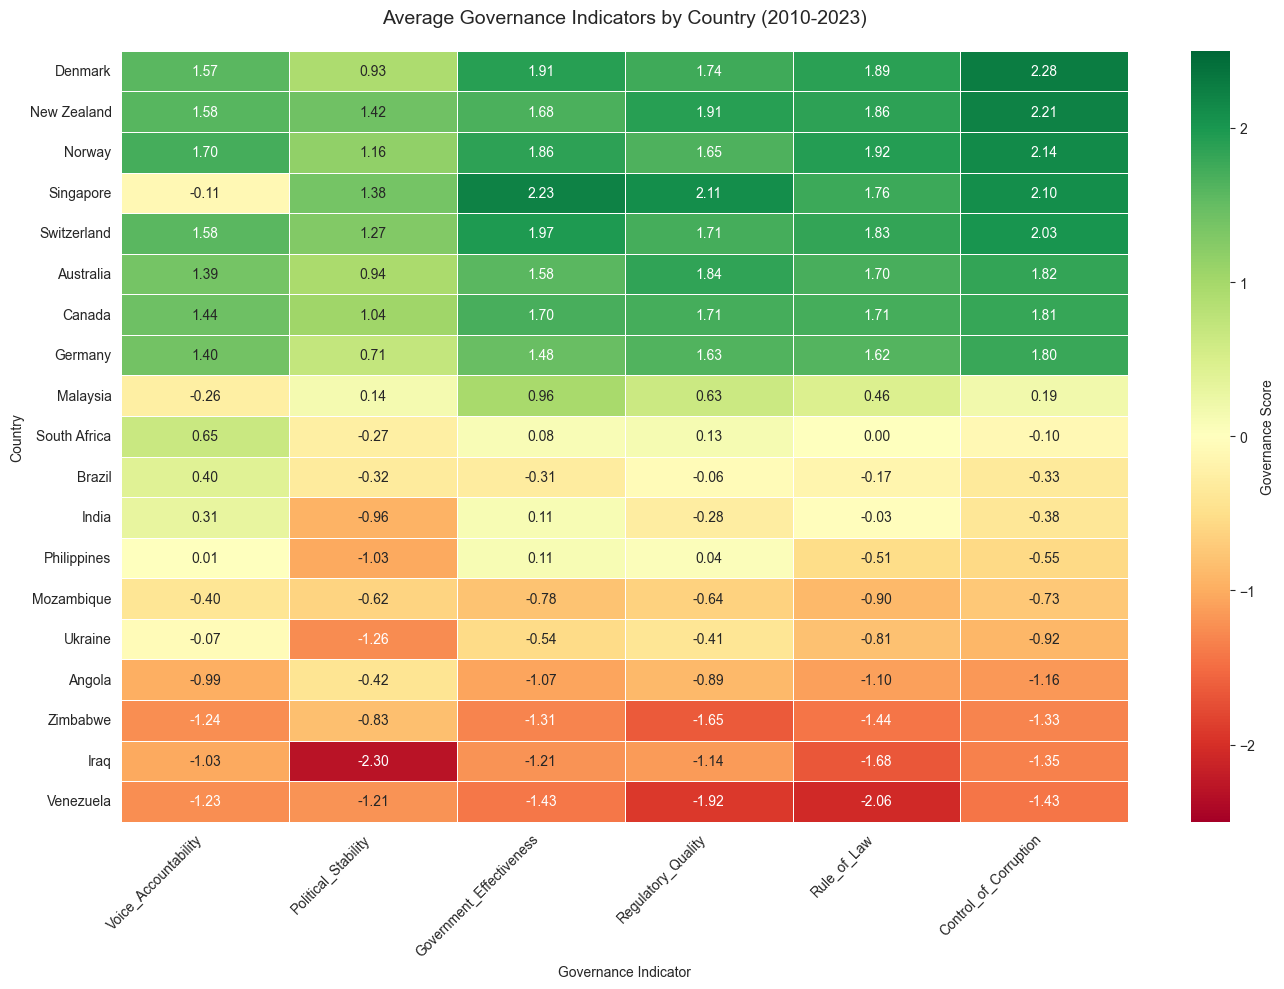

In [ ]:
# create heatmap of average governance scores by country
gov_avg = df_expanded.groupby('Country')[indicators].mean()

# sort by Control_of_Corruption (key indicator)
gov_avg_sorted = gov_avg.sort_values('Control_of_Corruption', ascending=False)

# create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(gov_avg_sorted, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Governance Score'}, linewidths=0.5, vmin=-2.5, vmax=2.5)
plt.title('Average Governance Indicators by Country (2010-2023)', fontsize=14, pad=20)
plt.xlabel('Governance Indicator')
plt.ylabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('results/figures/03/expanded_governance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


### Control of Corruption over time by risk category


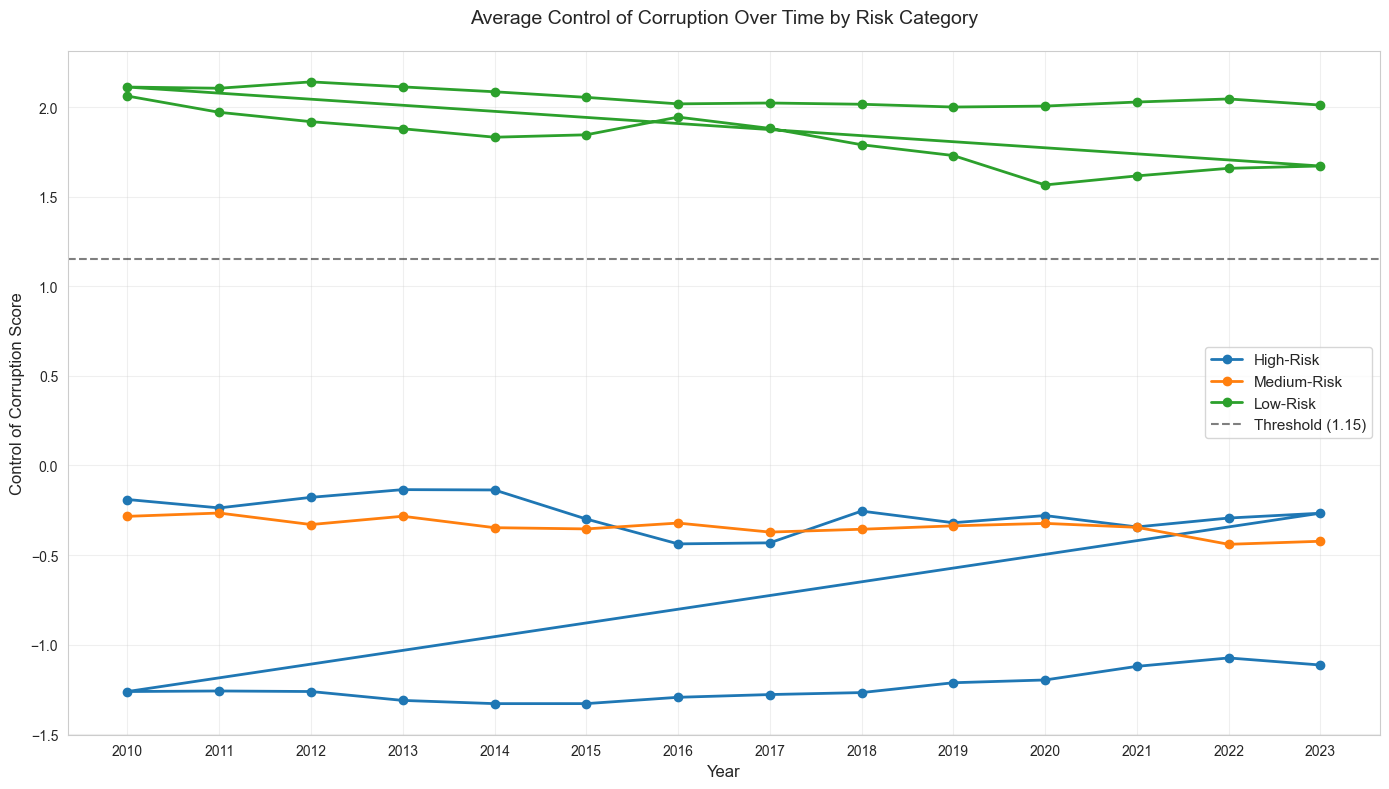

In [ ]:
# plot Control of Corruption over time by risk category
fig, ax = plt.subplots(figsize=(14, 8))

# calculate average by risk category and year
for category in ['High-Risk', 'Medium-Risk', 'Low-Risk']:
    category_data = df_expanded[df_expanded['Risk_Category'] == category]
    yearly_avg = category_data.groupby('Year')['Control_of_Corruption'].mean()
    
    ax.plot(yearly_avg.index.astype(int), yearly_avg.values, 
            marker='o', label=category, linewidth=2, markersize=6)

# add threshold line
ax.axhline(y=1.15, color='black', linestyle='--', alpha=0.5, label='Threshold (1.15)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Control of Corruption Score', fontsize=12)
ax.set_title('Average Control of Corruption Over Time by Risk Category', fontsize=14, pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(2010, 2024))

plt.tight_layout()
plt.savefig('results/figures/03/expanded_corruption_control_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


### Country distribution by risk category


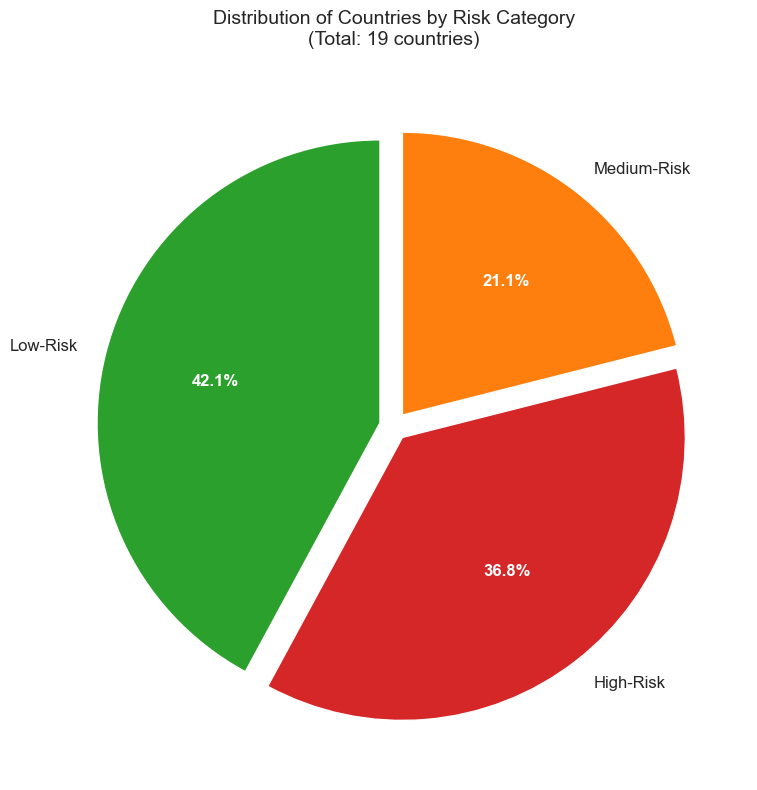


Countries by risk category:
High-Risk: 7 countries
Medium-Risk: 4 countries
Low-Risk: 8 countries


In [ ]:
# count unique countries by risk category (not rows)
risk_counts = df_expanded.groupby('Risk_Category')['Country'].nunique().sort_values(ascending=False)

# create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'High-Risk': '#d62728', 'Medium-Risk': '#ff7f0e', 'Low-Risk': '#2ca02c'}
explode = (0.05, 0.05, 0.05)

wedges, texts, autotexts = ax.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
                                  colors=[colors[cat] for cat in risk_counts.index],
                                  explode=explode, startangle=90, textprops={'fontsize': 12})

# enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('Distribution of Countries by Risk Category\n(Total: {} countries)'.format(df_expanded['Country'].nunique()), 
             fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('results/figures/03/expanded_risk_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCountries by risk category:")
print(f"High-Risk: {risk_counts.get('High-Risk', 0)} countries")
print(f"Medium-Risk: {risk_counts.get('Medium-Risk', 0)} countries")
print(f"Low-Risk: {risk_counts.get('Low-Risk', 0)} countries")


## Create Corruption Risk Labels for Expanded Dataset

Apply the same labeling strategy as notebook 02:
- 6 governance threshold checks (4+ flags = high risk)
- Create flags, total_flags, and corruption_risk columns


In [ ]:
# define thresholds (same as notebook 02)
thresholds = {
    'Voice_Accountability': 1.15,
    'Political_Stability': 0.50,
    'Government_Effectiveness': 1.15,
    'Regulatory_Quality': 1.15,
    'Rule_of_Law': 1.15,
    'Control_of_Corruption': 1.15
}

# create flag columns for each indicator
for indicator, threshold in thresholds.items():
    flag_col = f'{indicator}_flag'
    df_expanded[flag_col] = (df_expanded[indicator] < threshold).astype(int)

# count total flags per row
flag_cols = [f'{ind}_flag' for ind in thresholds.keys()]
df_expanded['total_flags'] = df_expanded[flag_cols].sum(axis=1)

# create corruption risk label: 4+ flags = high risk (1)
df_expanded['corruption_risk'] = (df_expanded['total_flags'] >= 4).astype(int)

print(f"\nFlag distribution across all {len(df_expanded)} country-years:")
print(df_expanded['total_flags'].value_counts().sort_index())
print(f"\nRisk label distribution:")
print(df_expanded['corruption_risk'].value_counts())
print(f"\nSummary:")
print(f"  Low Risk (0): {(df_expanded['corruption_risk'] == 0).sum()} rows ({(df_expanded['corruption_risk'] == 0).mean():.1%})")
print(f"  High Risk (1): {(df_expanded['corruption_risk'] == 1).sum()} rows ({(df_expanded['corruption_risk'] == 1).mean():.1%})")


### Summary by risk category


In [ ]:
# summary by country
print("Corruption risk summary by country:")
country_summary = df_expanded.groupby('Country').agg({
    'corruption_risk': ['sum', 'mean'],
    'total_flags': ['mean', 'max', 'min']
}).round(2)
country_summary.columns = ['High_Risk_Years', 'High_Risk_Rate', 'Avg_Flags', 'Max_Flags', 'Min_Flags']
country_summary = country_summary.sort_values('High_Risk_Rate', ascending=False)
print(country_summary)

# summary by risk category
print("\n\nCorruption risk summary by Risk Category:")
risk_category_summary = df_expanded.groupby('Risk_Category').agg({
    'corruption_risk': ['sum', 'mean'],
    'total_flags': ['mean', 'max', 'min'],
    'Country': 'nunique'
}).round(2)
risk_category_summary.columns = ['Total_High_Risk_Years', 'High_Risk_Rate', 'Avg_Flags', 'Max_Flags', 'Min_Flags', 'Num_Countries']
print(risk_category_summary)


## NEW: 19-Country Flag and Risk Visualizations

These graphs show the complete training dataset (all 19 countries, 266 country-years)


### 1. Flags Distribution Across All 266 Country-Years


In [ ]:
# histogram of total flags across all 266 country-years
fig, ax = plt.subplots(figsize=(12, 7))

# create histogram
flag_counts = df_expanded['total_flags'].value_counts().sort_index()
colors = ['green' if x < 4 else 'red' for x in flag_counts.index]

bars = ax.bar(flag_counts.index, flag_counts.values, color=colors, alpha=0.7, edgecolor='black')

# add threshold line
ax.axvline(x=3.5, color='black', linestyle='--', linewidth=2, label='High Risk Threshold (4+)')

# add annotations on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Number of Governance Flags (0-6)', fontsize=12)
ax.set_ylabel('Frequency (Country-Years)', fontsize=12)
ax.set_title('Distribution of Governance Flags Across All 19 Countries (2010-2023)\nTotal: 266 Country-Years', 
             fontsize=14, pad=20)
ax.set_xticks(range(0, 7))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# add text box with summary statistics
textstr = f'Low Risk (0-3 flags): {(df_expanded["total_flags"] < 4).sum()} country-years\nHigh Risk (4-6 flags): {(df_expanded["total_flags"] >= 4).sum()} country-years'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('results/figures/03/expanded_flags_distribution_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDetailed breakdown:")
print(f"{'Flags':<10} {'Count':<10} {'Percentage':<15} {'Risk Level'}")
print("-" * 50)
for flags in range(7):
    count = (df_expanded['total_flags'] == flags).sum()
    pct = count / len(df_expanded) * 100
    risk = 'LOW RISK' if flags < 4 else 'HIGH RISK'
    print(f"{flags:<10} {count:<10} {pct:<15.1f}% {risk}")


### 2. Total Flags Heatmap (19 Countries Over Time)


In [ ]:
# create heatmap showing total flags for all 19 countries over time
pivot_flags = df_expanded.pivot_table(index='Country', columns='Year', values='total_flags')

# sort by average flags (highest risk at top)
pivot_flags = pivot_flags.loc[pivot_flags.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_flags, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Flags (0-6)'}, linewidths=0.5, 
            vmin=0, vmax=6)
plt.title('Total Governance Flags by Country and Year (All 19 Countries)\n4+ Flags = High Risk', 
          fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('results/figures/03/expanded_total_flags_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


### 3. Risk Labels Heatmap (19 Countries Over Time)


In [ ]:
# create heatmap showing corruption risk labels for all 19 countries over time
pivot_risk = df_expanded.pivot_table(index='Country', columns='Year', values='corruption_risk')

# sort by average risk (highest risk at top)
pivot_risk = pivot_risk.loc[pivot_risk.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_risk, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Corruption Risk (0=Low, 1=High)'}, 
            linewidths=0.5, vmin=0, vmax=1)
plt.title('Corruption Risk Labels by Country and Year (All 19 Countries)\n0 = Low Risk (<4 flags), 1 = High Risk (4+ flags)', 
          fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('results/figures/03/expanded_corruption_risk_labels_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


### 4. Risk Distribution by Category (Bar Chart)


In [ ]:
# create stacked bar chart showing risk distribution by category
fig, ax = plt.subplots(figsize=(12, 7))

# group by risk category and corruption risk
risk_by_category = df_expanded.groupby(['Risk_Category', 'corruption_risk']).size().unstack(fill_value=0)

# create stacked bar chart
risk_by_category.plot(kind='bar', stacked=True, ax=ax, 
                      color=['#2ca02c', '#d62728'], alpha=0.8, edgecolor='black')

# customize
ax.set_xlabel('Country Risk Category', fontsize=12)
ax.set_ylabel('Number of Country-Years', fontsize=12)
ax.set_title('Distribution of Corruption Risk Labels by Country Category\n(All 266 Country-Years)', 
             fontsize=14, pad=20)
ax.legend(['Low Risk (0)', 'High Risk (1)'], title='Risk Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, alpha=0.3, axis='y')

# add value labels on bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/03/expanded_risk_distribution_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# print statistics
print("\nRisk label distribution by category:")
print(risk_by_category)
print("\nPercentage high-risk by category:")
for category in risk_by_category.index:
    total = risk_by_category.loc[category].sum()
    high_risk = risk_by_category.loc[category, 1] if 1 in risk_by_category.columns else 0
    pct = high_risk / total * 100
    print(f"{category}: {pct:.1f}% ({high_risk}/{total} country-years)")


## Save Labeled Expanded Dataset

Save the complete labeled dataset to use for model training


In [ ]:
# save to processed directory  
os.makedirs('data/processed', exist_ok=True)
output_path = 'data/processed/corruption_data_expanded_labeled.csv'
df_expanded.to_csv(output_path, index=False)

print(f"Saved labeled dataset to: {output_path}")
print(f"\nFinal dataset shape: {df_expanded.shape}")
print(f"Columns: {len(df_expanded.columns)}")
print(f"\nColumn names:")
print(df_expanded.columns.tolist())

print(f"\n\n=== FINAL SUMMARY ===")
print(f"Total observations: {len(df_expanded)} country-years")
print(f"Countries: {df_expanded['Country'].nunique()}")
print(f"Years: {df_expanded['Year'].min()} - {df_expanded['Year'].max()}")
print(f"\nRisk Distribution:")
print(f"  Low Risk (0): {(df_expanded['corruption_risk'] == 0).sum()} ({(df_expanded['corruption_risk'] == 0).mean():.1%})")
print(f"  High Risk (1): {(df_expanded['corruption_risk'] == 1).sum()} ({(df_expanded['corruption_risk'] == 1).mean():.1%})")
print(f"\nReady for model training!")
